In [131]:
# Cryostratigraphic Synthesis of Inuvik to Tuktoyaktuk Highway Corridor
# Geotechnical Boreholes (2012-2017)
# https://data.permafrostnet.ca/erddap/tabledap/ntgs-AC.htmlTable?latitude%2Clongitude%2Ctime%2Cborehole%2Cdepth%2Cfrozen%2Ccryostructures%2Cvisible_ice%2CASTM_2488%2Cmaterials%2Corganic_cover%2Ctop_of_interval%2Cbottom_of_interval
# see: https://data.permafrostnet.ca/erddap/tabledap/ntgs-AC.html
#    for a description of data fields

In [307]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sb

from xgboost import XGBClassifier
import xgboost
import shap

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

ModuleNotFoundError: No module named 'shap'

# Load Data

In [ ]:
df = pd.read_csv('data_stephen.csv', header=[0,1])

In [107]:
df.head()

,latitude,longitude,time,borehole,depth,frozen,cryostructures,visible_ice,ASTM_2488,materials,organic_cover,top_of_interval,bottom_of_interval
,degrees_north,degrees_east,UTC,Unnamed: 3_level_1,m,Unnamed: 5_level_1,Unnamed: 6_level_1,Unnamed: 7_level_1,Unnamed: 8_level_1,Unnamed: 9_level_1,m,m,m
0,69.16162,-133.08682,2012-03-21T00:00:00Z,0170-1-10,0.15,0,NaN,NaN,TOPSOIL,Organics,0.3,0.0,0.3
1,69.16162,-133.08682,2012-03-21T00:00:00Z,0170-1-10,0.85,1,NaN,Pure ice,ICE,Ice,0.3,0.3,1.4
2,69.16162,-133.08682,2012-03-21T00:00:00Z,0170-1-10,1.90,1,Nf,No visible ice,SW-SM,Coarse till,0.3,1.4,2.4
3,69.16162,-133.08682,2012-03-21T00:00:00Z,0170-1-10,5.40,1,Nf,No visible ice,GW-GM,Coarse till,0.3,2.4,8.4
4,69.16105,-133.08880,2012-03-21T00:00:00Z,0170-1-12,1.20,1,Nf,No visible ice,GP-GM,Coarse till,0.0,0.0,2.4


In [ ]:
# 68.36933	-133.82843 lower leftmost location of samples
# 69.44755	-132.89346 upper rightmost location of samples

# sample time range from march 18 2012, to march 21 2017

# Visualize Data

Number of Nans:  Unnamed: 3_level_1    0
dtype: int64


/Users/jarrodhaas/.local/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


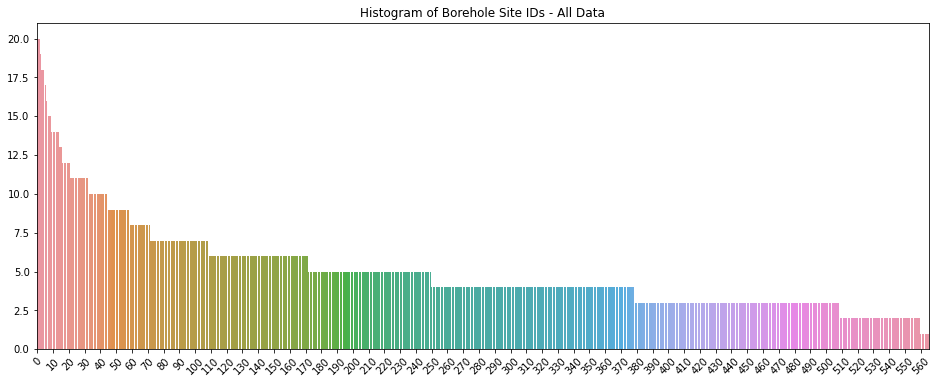

In [132]:
print("Number of Nans: ", df.borehole.isna().sum())

# plot a categorical histogram of each column

num_bh = df.borehole.value_counts().shape[0]

plt.figure(figsize=(16,6))
b = sb.barplot(np.arange(num_bh), df.borehole.value_counts())
b = b.set_xticklabels(np.arange(0,num_bh,10), rotation=45)
plt.xticks(np.arange(0,num_bh,10))
# plt.grid()
plt.title('Histogram of Borehole Site IDs - All Data')
plt.show()

Number of Nans:  Unnamed: 3_level_1    0
dtype: int64


/Users/jarrodhaas/.local/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


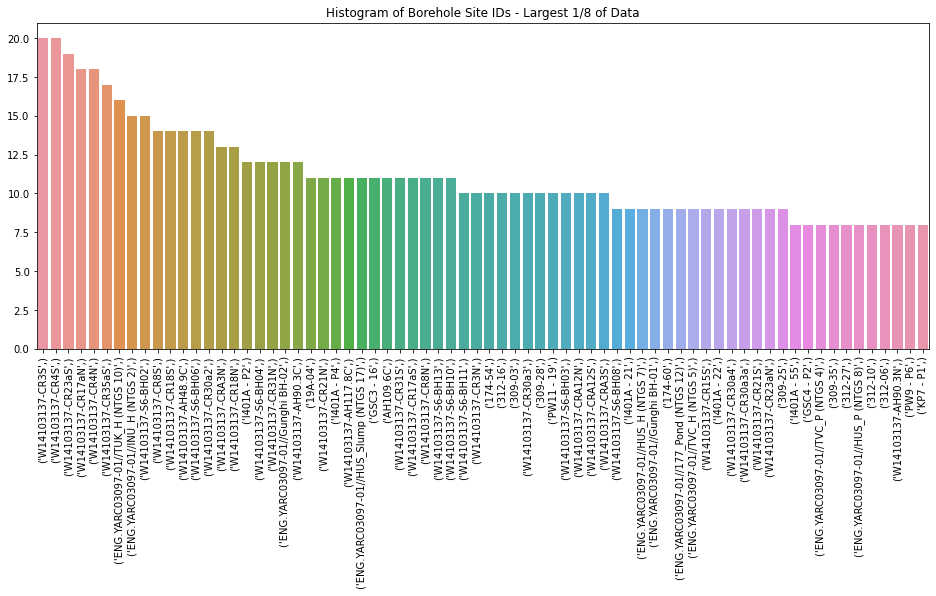

In [89]:
print("Number of Nans: ", df.borehole.isna().sum())

# plot a categorical histogram of each column

num_bh = df.borehole.value_counts().shape[0]

plt.figure(figsize=(16,6))
plt.xticks(np.arange(int(num_bh/8)), df.borehole.value_counts().index[:int(num_bh/8)], rotation=90)
b = sb.barplot(np.arange(int(num_bh/8)), df.borehole.value_counts()[:int(num_bh/8)])
b.set_xticklabels(df.borehole.value_counts().index[:int(num_bh/8)], rotation=90)

# plt.yticks(np.arange(0,600,50))
# plt.grid()
plt.title('Histogram of Borehole Site IDs - Largest 1/8 of Data')
plt.show()

Number of Nans:  m    0
dtype: int64


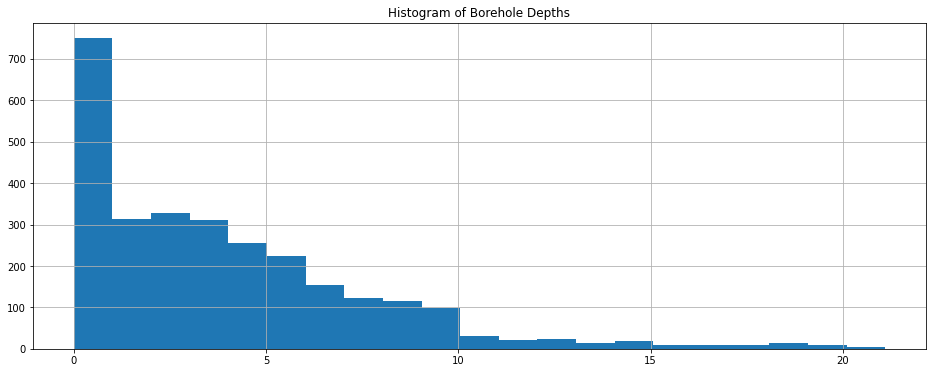

In [129]:
# This appears to be the center-depth of the borehole interval that was sampled
# e.g. if sample interval is 3 to 6 meters, depth would be 4.5


print("Number of Nans: ", df.depth.isna().sum())

plt.figure(figsize=(16,6))
plt.hist(df['depth'].values, bins=21)

# plt.yticks(np.arange(0,600,50))
plt.grid()
plt.title('Histogram of Borehole Depths')
plt.show()

Number of Nans:  Unnamed: 5_level_1    0
dtype: int64


/Users/jarrodhaas/.local/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


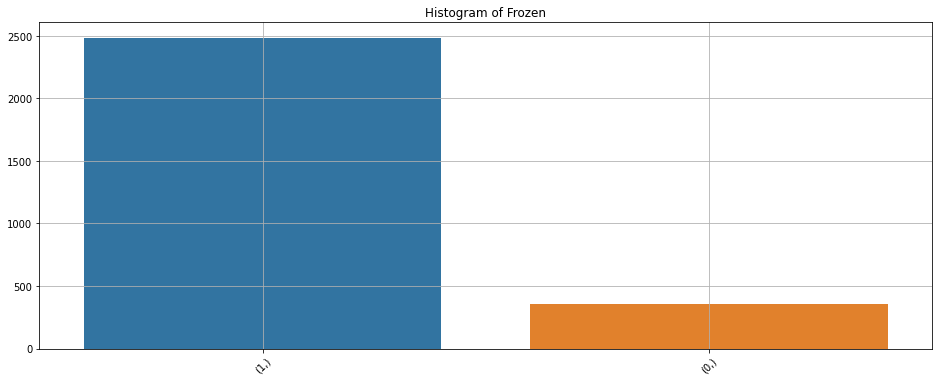

In [125]:
# plot a categorical histogram of each column

print("Number of Nans: ", df.frozen.isna().sum())

plt.figure(figsize=(16,6))
b = sb.barplot(np.arange(df.frozen.value_counts().shape[0]), df.frozen.value_counts())
b.set_xticklabels(df.frozen.value_counts().index, rotation=45)

# plt.yticks(np.arange(0,600,50))
plt.grid()
plt.title('Histogram of Frozen')
plt.show()

Number of Nans:  Unnamed: 6_level_1    1029
dtype: int64


/Users/jarrodhaas/.local/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


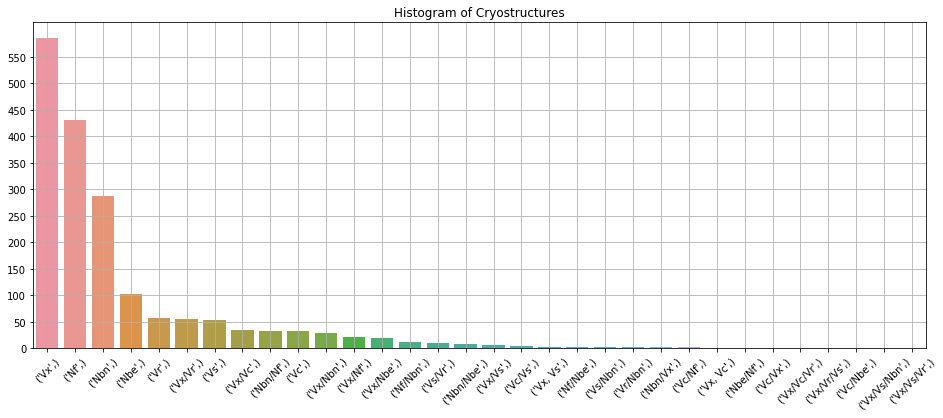

In [126]:
# "cryostructure": the structural characteristics of frozen earth materials

print("Number of Nans: ", df.cryostructures.isna().sum())

plt.figure(figsize=(16,6))
b = sb.barplot(np.arange(32), df.cryostructures.value_counts())
b.set_xticklabels(df.cryostructures.value_counts().index, rotation=45)

plt.yticks(np.arange(0,600,50))
plt.grid()
plt.title('Histogram of Cryostructures')
plt.show()

Number of Nans:  Unnamed: 8_level_1    541
dtype: int64


/Users/jarrodhaas/.local/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


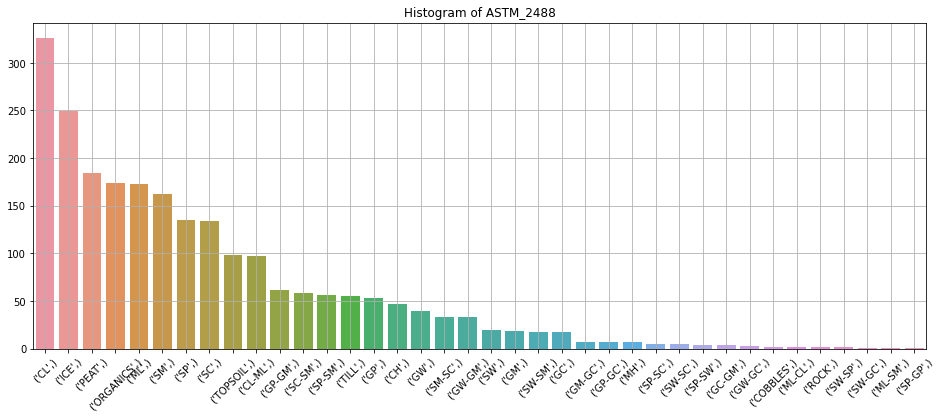

In [133]:
# ASTM_2488
# a standardized way of classifying soil characteristics
# see https://socwisconsin.org/wp-content/uploads/2017/01/ASTM-D-2488-visual-USCS.pdf

print("Number of Nans: ", df.ASTM_2488.isna().sum())

plt.figure(figsize=(16,6))
b = sb.barplot(np.arange(df.ASTM_2488.value_counts().shape[0]), df.ASTM_2488.value_counts())
b.set_xticklabels(df.ASTM_2488.value_counts().index, rotation=45)

# plt.yticks(np.arange(0,600,50))
plt.grid()
plt.title('Histogram of ASTM_2488')
plt.show()

Number of Nans:  0


/Users/jarrodhaas/.local/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


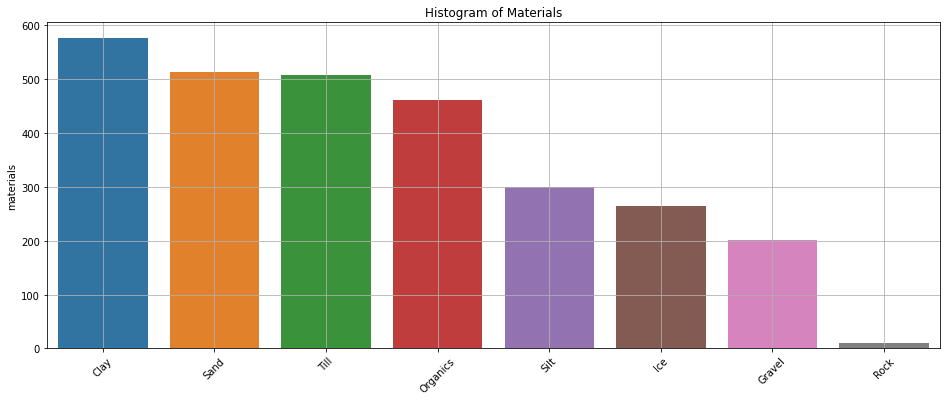

In [169]:
# Materials

print("Number of Nans: ", df.materials.isna().sum())

plt.figure(figsize=(16,6))
b = sb.barplot(np.arange(df.materials.value_counts().shape[0]), df.materials.value_counts())
b.set_xticklabels(df.materials.value_counts().index, rotation=45)

# plt.yticks(np.arange(0,600,50))
plt.grid()
plt.title('Histogram of Materials')
plt.show()

Number of Nans:  m    0
dtype: int64


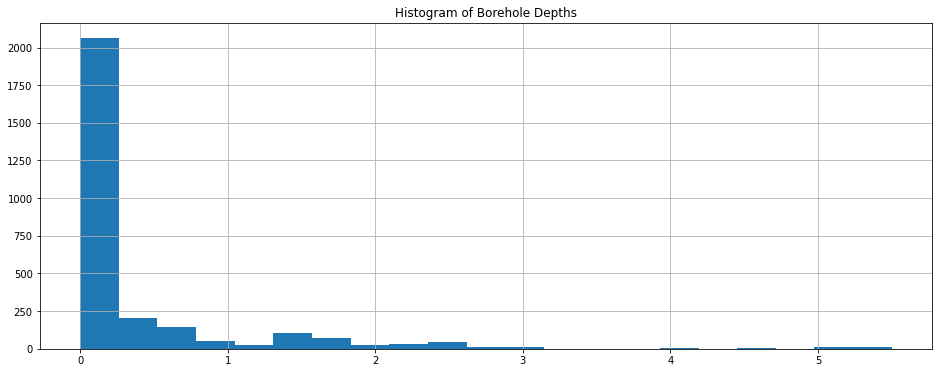

In [130]:
print("Number of Nans: ", df.organic_cover.isna().sum())

plt.figure(figsize=(16,6))
plt.hist(df['organic_cover'].values, bins=21)

# plt.yticks(np.arange(0,600,50))
plt.grid()
plt.title('Histogram of Borehole Depths')
plt.show()

# Experiment 1

In [251]:
df = pd.read_csv('data_stephen_fix_header.csv', header=[0])

In [244]:
# merge materials (target) classes
# types of ice -> ice
# types of till -> till

# df['materials'].replace(['ICE'], 'ice', regex=True, inplace=True)
df['materials'].replace(['ICE'], 'Ice', regex=True, inplace=True)
df['materials'].replace(['ice'], 'Ice', regex=True, inplace=True)
df['materials'].replace(['Pure Ice'], 'Ice', regex=True, inplace=True)

df['materials'].replace(['Coarse till'], 'Till', regex=True, inplace=True)
df['materials'].replace(['till'], 'Till', regex=True, inplace=True)
df['materials'].replace(['Fine till'], 'Till', regex=True, inplace=True)
df['materials'].replace(['Fine Till'], 'Till', regex=True, inplace=True)

df['materials'].replace(['Cobbles'], 'Gravel', regex=True, inplace=True)

df.materials = df.materials.astype('category').cat.codes

# convert timecodes to year and month columns
datetimes = pd.to_datetime(df['time'])
df['month'] = datetimes.dt.month
df['year'] = datetimes.dt.year

df2 = df.filter(['latitude', 'longitude', 'year', 'month', 'depth', 'organic_cover', 'materials'])
data = np.array(df2.drop('materials', axis=1))
labels = np.array(df2.materials.astype(int))

In [205]:
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=0)

classifier = XGBClassifier()
classifier.fit(X_train, y_train) 

/Users/jarrodhaas/.pyenv/versions/3.7.3/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[10:08:27] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=12, num_parallel_tree=1,
              objective='multi:softprob', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [207]:
y_pred = classifier.predict(X_test)

print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))
print(accuracy_score(y_test, y_pred))

[[76  2  7  1  0 17 10  6]
 [ 0 20  2  0  0 15  1  5]
 [ 9  6 10  1  0  9  5  9]
 [ 0  1  1 86  0  1  3  0]
 [ 2  0  0  0  1  0  0  0]
 [23  5  9  0  0 39 13 14]
 [ 9  0  8  4  0 12 15  5]
 [ 8  5  6  0  0 15  7 65]]
              precision    recall  f1-score   support

           0       0.60      0.64      0.62       119
           1       0.51      0.47      0.49        43
           2       0.23      0.20      0.22        49
           3       0.93      0.93      0.93        92
           4       1.00      0.33      0.50         3
           5       0.36      0.38      0.37       103
           6       0.28      0.28      0.28        53
           7       0.62      0.61      0.62       106

    accuracy                           0.55       568
   macro avg       0.57      0.48      0.50       568
weighted avg       0.55      0.55      0.55       568

0.5492957746478874


# Experiment 2

In [261]:
df = pd.read_csv('data_stephen_fix_header.csv', header=[0])

In [262]:
# merge materials (target) classes
# types of ice -> ice
# types of till -> till

# df['materials'].replace(['ICE'], 'ice', regex=True, inplace=True)
df['materials'].replace(['ICE'], 'Ice', regex=True, inplace=True)
df['materials'].replace(['ice'], 'Ice', regex=True, inplace=True)
df['materials'].replace(['Pure Ice'], 'Ice', regex=True, inplace=True)

df['materials'].replace(['Coarse till'], 'Till', regex=True, inplace=True)
df['materials'].replace(['till'], 'Till', regex=True, inplace=True)
df['materials'].replace(['Fine till'], 'Till', regex=True, inplace=True)
df['materials'].replace(['Fine Till'], 'Till', regex=True, inplace=True)

df['materials'].replace(['Till'], 'Sand', regex=True, inplace=True)
df['materials'].replace(['Silt'], 'Sand', regex=True, inplace=True)

df['materials'].replace(['Cobbles'], 'Gravel', regex=True, inplace=True)

df.materials = df.materials.astype('category').cat.codes

# convert timecodes to year and month columns
datetimes = pd.to_datetime(df['time'])
df['month'] = datetimes.dt.month
df['year'] = datetimes.dt.year

df2 = df.filter(['latitude', 'longitude', 'year', 'month', 'depth', 'organic_cover', 'materials'])
data = np.array(df2.drop('materials', axis=1))
labels = np.array(df2.materials.astype(int))

In [264]:
df_c = df.copy()
df.materials = df.materials.astype('category').cat.codes

In [278]:
df_c[df.materials==6]

,latitude,longitude,time,borehole,depth,frozen,cryostructures,visible_ice,ASTM_2488,materials,organic_cover,top_of_interval,bottom_of_interval


In [297]:
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2)

classifier = XGBClassifier()
classifier.fit(X_train, y_train) 

/Users/jarrodhaas/.pyenv/versions/3.7.3/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[10:45:27] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=12, num_parallel_tree=1,
              objective='multi:softprob', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [298]:
y_pred = classifier.predict(X_test)

print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))
print(accuracy_score(y_test, y_pred))

[[ 76   0   7   1   0  35]
 [  0  15   2   1   0  25]
 [  8   3   9   0   0  30]
 [  1   0   3  89   0   7]
 [  1   0   0   0   1   0]
 [ 35  11  14   1   0 193]]
              precision    recall  f1-score   support

           0       0.63      0.64      0.63       119
           1       0.52      0.35      0.42        43
           2       0.26      0.18      0.21        50
           3       0.97      0.89      0.93       100
           4       1.00      0.50      0.67         2
           5       0.67      0.76      0.71       254

    accuracy                           0.67       568
   macro avg       0.67      0.55      0.59       568
weighted avg       0.66      0.67      0.67       568

0.6742957746478874


In [303]:
df2.head()

,latitude,longitude,year,month,depth,organic_cover,materials
0,69.16162,-133.08682,2012,3,0.15,0.3,3
1,69.16162,-133.08682,2012,3,0.85,0.3,2
2,69.16162,-133.08682,2012,3,1.90,0.3,5
3,69.16162,-133.08682,2012,3,5.40,0.3,5
4,69.16105,-133.08880,2012,3,1.20,0.0,5


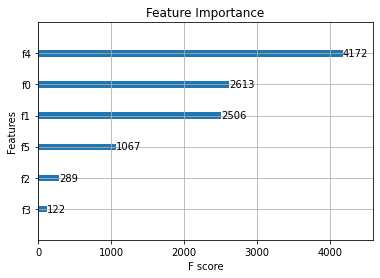

In [304]:
xgboost.plot_importance(classifier, importance_type="cover")
plt.title("Feature Importance")
plt.show()

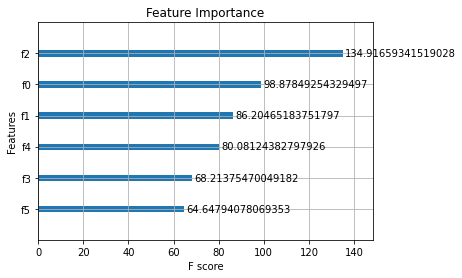

In [305]:
xgboost.plot_importance(classifier, importance_type="cover")
plt.title("Feature Importance")
plt.show()

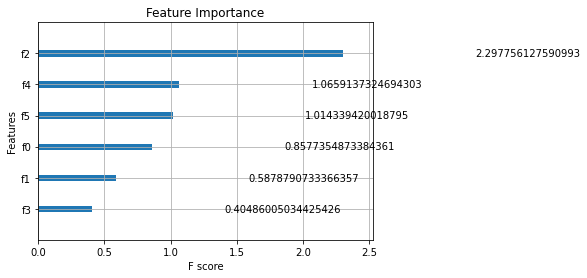

In [306]:
xgboost.plot_importance(classifier, importance_type="gain")
plt.title("Feature Importance")
plt.show()